# 🏀 NBA Contract Evaluator

This project explores whether NBA players are overpaid or underpaid relative to their on-court performance by combining basketball statistics with machine learning.

Using data scraped from sources like Basketball Reference and Spotrac, we collected player performance metrics (e.g., points, assists, win shares, BPM) and salary data across multiple seasons. We then trained an XGBoost classifier to predict whether a player’s contract is aligned with their performance, aiming to identify market inefficiencies.

Key components of the project include:
- Data cleaning of NBA stats and contract information
- Exploratory data analysis to uncover trends in salary vs. performance
- Feature engineering with normalized stats and role-based grouping
- Predictive modeling using XGBoost to flag potential over- or under-valued contracts
- Interpretation via feature importance and example player breakdowns

This project demonstrates how statistical modeling can support decision-making in sports management, salary negotiations, and media analysis.

### Setup and Imports

In [ ]:
# Imports needed to run the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

c:\Users\ahsan\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Cleaning & Preprocessing

This section prepares a structured dataset by merging player performance statistics from the 2023–24 NBA season with 2024–25 salary data.

### Steps Overview

- **Loaded datasets**
  - `stats_data`: basic per-game statistics (e.g., PTS, AST, REB)
  - `advanced_stats_data`: advanced metrics (e.g., BPM, WS)
  - `contract_data`: player salary information for the 2024–25 season

- **Resolved player duplicates**
  - Players traded mid-season appeared under multiple teams
  - For both base and advanced stats, we retained the `'2TM'` row (aggregated totals) when duplicates were detected

- **Merged datasets**
  - Merged base and advanced stats on `Player`
  - Merged combined stats with 2024–25 contract data

- **Removed unnecessary columns**
  - Dropped future salary projections (2025–30), rank columns, and unused metadata

- **Renamed and reformatted**
  - Renamed `Team_x` to `Team` and `2024–25` to `Contract 2024–25`
  - Cleaned the salary column (e.g., removed `$`, `,`) and converted to integer

- **Final preprocessing**
  - One-hot encoded the `Pos` (player position) column
  - Filled missing numeric values with column means

The resulting dataset contains one row per player, combining both traditional and advanced stats from 2023–24 with their corresponding 2024–25 contract value in clean, numeric format.

In [125]:
stats_data = pd.read_csv('data/NBA 2023-24 Stats Data - Sheet1.csv')
stats_data.head()

,Rank,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Joel Embiid,29,PHI,C,39,39,33.6,11.5,21.8,...,0.883,2.4,8.6,11.0,5.6,1.2,1.7,3.8,2.9,34.7
1,2,Luka Dončić,24,DAL,PG,70,70,37.5,11.5,23.6,...,0.786,0.8,8.4,9.2,9.8,1.4,0.5,4.0,2.1,33.9
2,3,Giannis Antetokounmpo,29,MIL,PF,73,73,35.2,11.5,18.8,...,0.657,2.7,8.8,11.5,6.5,1.2,1.1,3.4,2.9,30.4
3,4,Shai Gilgeous-Alexander,25,OKC,PG,75,75,34.0,10.6,19.8,...,0.874,0.9,4.7,5.5,6.2,2.0,0.9,2.2,2.5,30.1
4,5,Jalen Brunson,27,NYK,PG,77,77,35.4,10.3,21.4,...,0.847,0.6,3.1,3.6,6.7,0.9,0.2,2.4,1.9,28.7


In [126]:
contract_data = pd.read_csv('data/NBA Contract Data - Sheet1.csv')
contract_data.head()

,Rank,Player,Team,2024-25,2025-26,2026-27,2027-28,2028-29,2029-30,Guaranteed
0,1,Stephen Curry,GSW,"$55,761,216","$59,606,817",NaN,NaN,NaN,NaN,"$115,368,033"
1,2,Nikola Jokić,DEN,"$51,415,938","$55,224,526","$59,033,114","$62,841,702",NaN,NaN,"$165,673,578"
2,3,Joel Embiid,PHI,"$51,415,938","$55,224,526",NaN,NaN,NaN,NaN,"$106,640,464"
3,4,Kevin Durant,PHO,"$51,179,021","$54,708,609",NaN,NaN,NaN,NaN,"$105,887,630"
4,5,Bradley Beal,PHO,"$50,203,930","$53,666,270","$57,128,610",NaN,NaN,NaN,"$103,870,200"


In [127]:
advanced_stats_data = pd.read_csv('data/NBA Advanced Stats 2023-24 Season - Sheet1.csv')
advanced_stats_data.head()

,Player,Age,Team,Pos,G,GS,MP,PER,TS%,3PAr,...,TOV%,USG%,OwS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,DeMar DeRozan,34,CHI,SF,79,79,2989,19.7,0.584,0.166,...,7.7,25.8,7.0,2.2,9.2,0.147,2.1,-0.3,1.8,2.8
1,Domantas Sabonis,27,SAC,C,82,82,2928,23.2,0.637,0.081,...,17.9,22.2,8.6,4.0,12.6,0.206,4.0,2.4,6.5,6.2
2,Coby White,23,CHI,PG,79,78,2881,14.5,0.570,0.460,...,11.1,22.7,3.1,1.6,4.7,0.078,0.7,-1.3,-0.7,0.9
3,Mikal Bridges,27,BRK,SF,82,82,2854,14.9,0.560,0.457,...,10.3,24.3,2.1,2.1,4.2,0.070,0.7,-1.0,-0.4,1.2
4,Paolo Banchero,21,ORL,PF,80,80,2799,17.3,0.546,0.249,...,13.0,29.7,1.3,4.0,5.3,0.090,1.3,0.0,1.3,2.3


In [128]:
# Step 1: Handle duplicates in base stats
dup_stats = stats_data[stats_data.duplicated(subset='Player', keep=False)]
filtered_stats_data = stats_data[
    ~stats_data['Player'].isin(dup_stats['Player']) | (stats_data['Team'] == '2TM')
]

# Step 2: Handle duplicates in advanced stats
dup_advanced = advanced_stats_data[advanced_stats_data.duplicated(subset='Player', keep=False)]
filtered_advanced_stats = advanced_stats_data[
    ~advanced_stats_data['Player'].isin(dup_advanced['Player']) | (advanced_stats_data['Team'] == '2TM')
]

# Step 3: Merge base stats + advanced stats on Player
combined_stats = pd.merge(filtered_stats_data, filtered_advanced_stats, on='Player', how='inner', suffixes=('', '_adv'))

# Optional: drop duplicate 'Team_adv' if present from advanced data
if 'Team_adv' in combined_stats.columns:
    combined_stats.drop(columns=['Team_adv'], inplace=True)

# Step 4: Merge with contract data
merged_data = pd.merge(combined_stats, contract_data, on='Player', how='inner')
merged_data.head()

,Rank_x,Player,Age,Team_x,Pos,G,GS,MP,FG,FGA,...,VORP,Rank_y,Team_y,2024-25,2025-26,2026-27,2027-28,2028-29,2029-30,Guaranteed
0,1,Joel Embiid,29,PHI,C,39,39,33.6,11.5,21.8,...,4.5,3,PHI,"$51,415,938","$55,224,526",NaN,NaN,NaN,NaN,"$106,640,464"
1,2,Luka Dončić,24,DAL,PG,70,70,37.5,11.5,23.6,...,8.0,18,DAL,"$43,031,940","$45,999,660","$48,967,380",NaN,NaN,NaN,"$89,031,600"
2,3,Giannis Antetokounmpo,29,MIL,PF,73,73,35.2,11.5,18.8,...,7.2,12,MIL,"$48,787,676","$54,126,450","$58,456,566","$62,786,682",NaN,NaN,"$161,370,692"
3,4,Shai Gilgeous-Alexander,25,OKC,PG,75,75,34.0,10.6,19.8,...,7.1,34,OKC,"$35,859,950","$38,333,050","$40,806,150",NaN,NaN,NaN,"$114,999,150"
4,5,Jalen Brunson,27,NYK,PG,77,77,35.4,10.3,21.4,...,5.4,66,NYK,"$24,960,001","$34,944,001","$37,739,521","$40,535,041","$43,330,561",NaN,"$138,178,564"


In [129]:
# Step 4: Define the columns to drop
# We are dropping both rank columns ('Rank_x', 'Rank_y') and the contract-related columns for future seasons 
columns_to_drop = ['Rank_x', 'Rank_y', '2025-26', '2026-27', '2027-28', '2028-29', '2029-30', 'Guaranteed', "Team_y", 'Pos_adv']

# Step 5: Drop these columns from the merged data
# The drop() method removes the specified columns from the DataFrame
cleaned_merged_data = merged_data.drop(columns=columns_to_drop)

# Step 6: Select only the relevant columns for the final output
# We are keeping the 'Player' name, 'Age', 'Team_x' (which we will rename to 'Team'), stats columns (G, GS, MP, etc.), 
# and the contract column for the 2024-25 season ('2024-25')
final_data = cleaned_merged_data
# Step 7: Rename columns for clarity
# Rename 'Team_x' to 'Team' and '2024-25' to 'Contract 2024-25' to make the column names more descriptive
final_data.rename(columns={'Team_x': 'Team', '2024-25': 'Contract 2024-25'}, inplace=True)

In [130]:
# Step 8: Convert the 'Contract 2024-25' column to an integer type
final_data['Contract 2024-25'] = final_data['Contract 2024-25'].str.replace('$', '').str.replace(',', '').astype(int)
final_data.head()

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,USG%,OwS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Contract 2024-25
0,Joel Embiid,29,PHI,C,39,39,33.6,11.5,21.8,0.529,...,39.6,5.2,2.3,7.5,0.275,8.5,3.1,11.6,4.5,51415938
1,Luka Dončić,24,DAL,PG,70,70,37.5,11.5,23.6,0.487,...,36.0,8.5,3.5,12.0,0.220,8.3,1.7,9.9,8.0,43031940
2,Giannis Antetokounmpo,29,MIL,PF,73,73,35.2,11.5,18.8,0.611,...,33.0,9.5,3.7,13.2,0.246,6.7,2.4,9.0,7.2,48787676
3,Shai Gilgeous-Alexander,25,OKC,PG,75,75,34.0,10.6,19.8,0.535,...,32.8,10.5,4.2,14.6,0.275,6.7,2.3,9.0,7.1,35859950
4,Jalen Brunson,27,NYK,PG,77,77,35.4,10.3,21.4,0.479,...,32.5,8.8,2.4,11.2,0.198,6.3,-0.4,5.8,5.4,24960001


In [131]:
# One-hot encode the 'Pos' column
one_hot_encoded_df = pd.get_dummies(final_data, columns = ['Pos'])
# Filled any empty values in the dataset
one_hot_encoded_df.fillna(one_hot_encoded_df.mean(numeric_only=True), inplace=True)
one_hot_encoded_df.head()

,Player,Age,Team,G,GS,MP,FG,FGA,FG%,3P,...,OBPM,DBPM,BPM,VORP,Contract 2024-25,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,Joel Embiid,29,PHI,39,39,33.6,11.5,21.8,0.529,1.4,...,8.5,3.1,11.6,4.5,51415938,True,False,False,False,False
1,Luka Dončić,24,DAL,70,70,37.5,11.5,23.6,0.487,4.1,...,8.3,1.7,9.9,8.0,43031940,False,False,True,False,False
2,Giannis Antetokounmpo,29,MIL,73,73,35.2,11.5,18.8,0.611,0.5,...,6.7,2.4,9.0,7.2,48787676,False,True,False,False,False
3,Shai Gilgeous-Alexander,25,OKC,75,75,34.0,10.6,19.8,0.535,1.3,...,6.7,2.3,9.0,7.1,35859950,False,False,True,False,False
4,Jalen Brunson,27,NYK,77,77,35.4,10.3,21.4,0.479,2.7,...,6.3,-0.4,5.8,5.4,24960001,False,False,True,False,False


## Exploratory Data Analysis (EDA)

We performed exploratory analysis to understand how player performance metrics from the 2023–24 NBA season relate to 2024–25 contract values.

> Note: We applied a log transformation to the 2024–25 salary data to reduce skew and improve model interpretability.

### Key Visualizations

- **Correlation Heatmap**  
  A correlation matrix of numeric features (including log-transformed salary) revealed strong positive relationships between salary and metrics like Win Shares (WS), Box Plus/Minus (BPM), and Value Over Replacement Player (VORP). These features were retained for modeling.

- **Histograms of Numeric Features**  
  Distributions for performance metrics such as points, rebounds, and minutes played were plotted. Log-scaling the salary column helped normalize its distribution and reduce the influence of extreme outliers.

- **Boxplot: Contract Value by Position**  
  A boxplot comparing log-scaled 2024–25 contract values across player positions showed notable variation. Guards tended to have lower median salaries compared to forwards and centers, though top earners were present in all positions.

### Insights

- Salary is most strongly correlated with advanced metrics like WS and BPM.
- The log transformation helped stabilize variance and improve numeric alignment with model inputs.
- Position influences salary trends, but performance metrics are more predictive.

These findings guided our feature selection and reinforced the need for scaling and transformation prior to modeling.

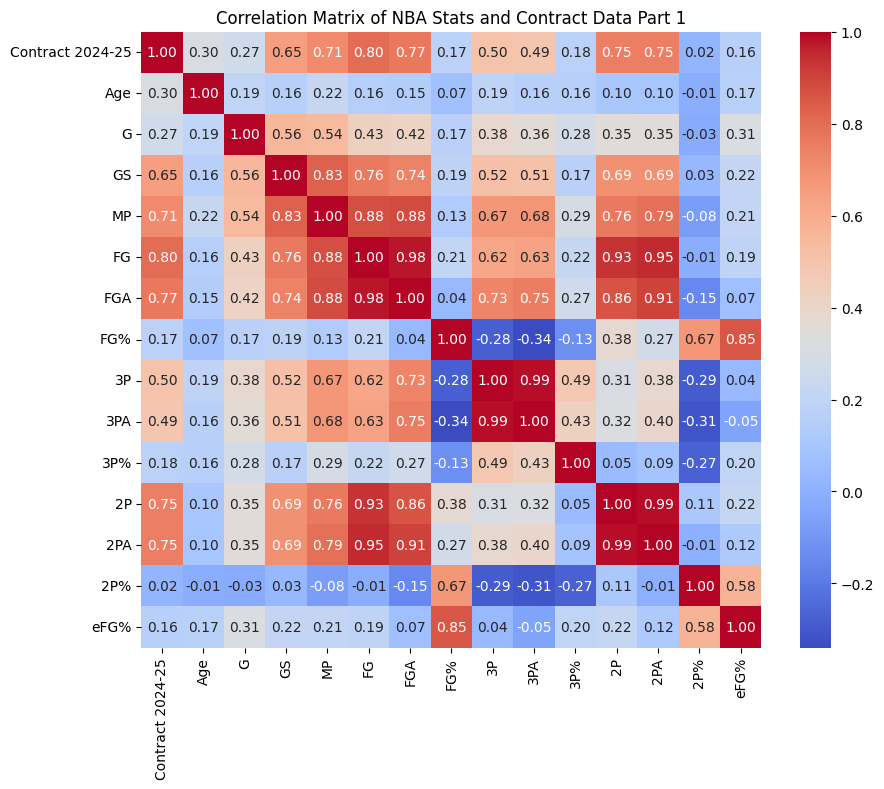

In [132]:
#Correlation matrix to visualize feature relationships
numeric_dfs = one_hot_encoded_df.drop(columns=['Player', 'Team'])
numeric_df_one = numeric_dfs[['Contract 2024-25', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%']]
numeric_df_two = numeric_dfs[[ 'Contract 2024-25', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
plt.figure(figsize=(10, 8))
correlation_matrix_one = numeric_df_one.corr()
sns.heatmap(correlation_matrix_one, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of NBA Stats and Contract Data Part 1")
plt.show()

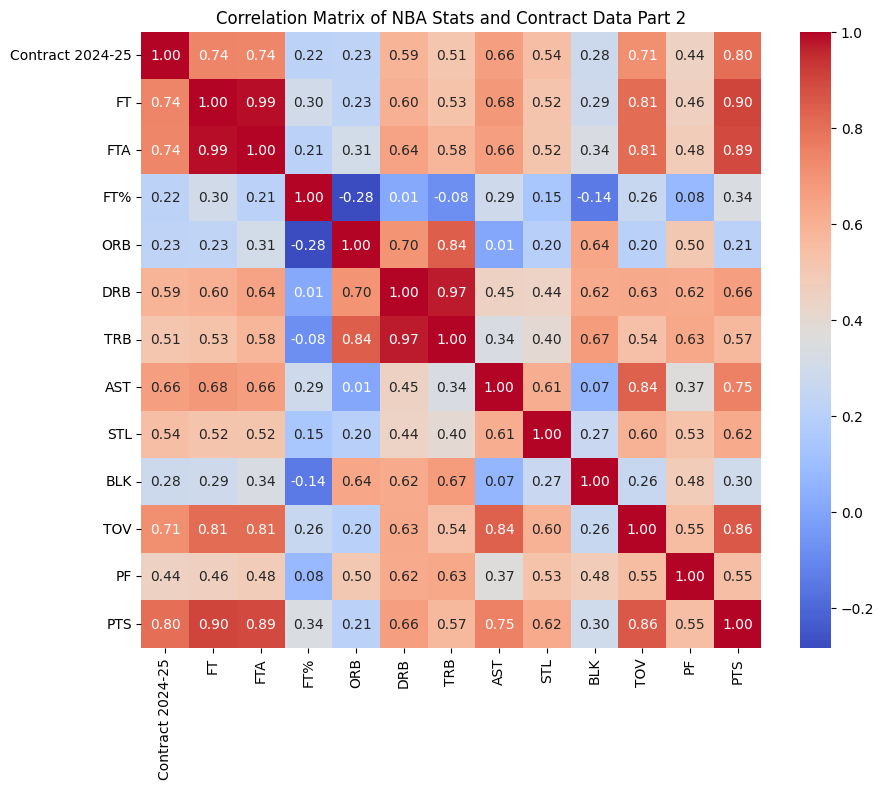

In [133]:
plt.figure(figsize=(10, 8))
correlation_matrix_two = numeric_df_two.corr()
sns.heatmap(correlation_matrix_two, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of NBA Stats and Contract Data Part 2")
plt.show()

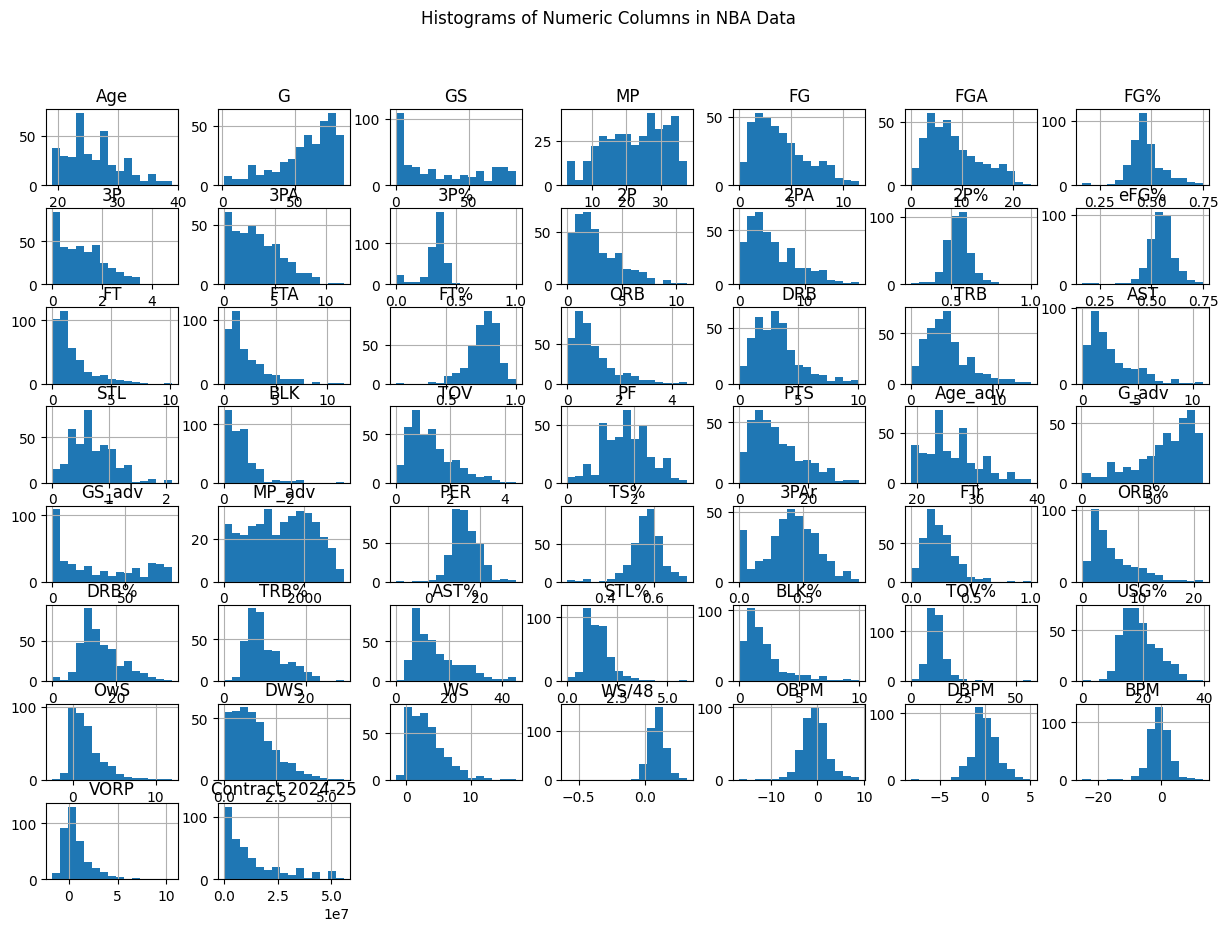

In [134]:
numeric_columns = one_hot_encoded_df.select_dtypes(include=['float64', 'int64']).columns
one_hot_encoded_df[numeric_columns].hist(bins=15, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Columns in NBA Data")
plt.show()

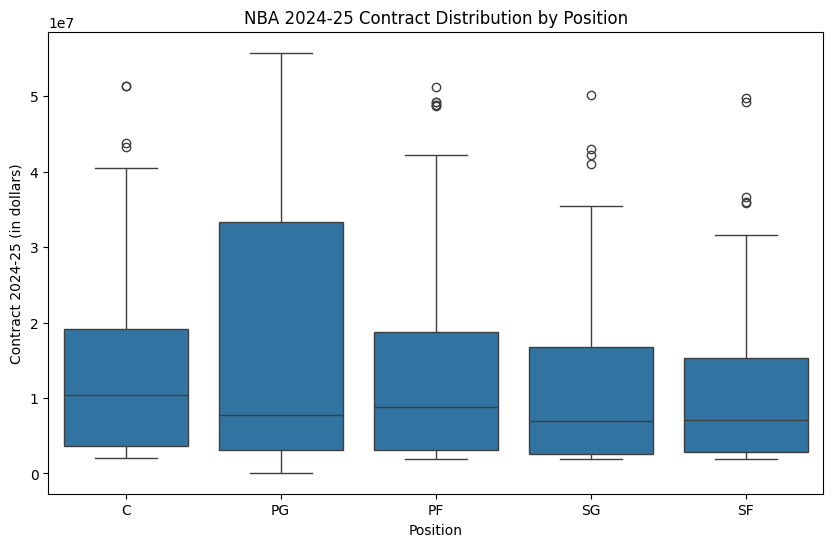

In [135]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pos', y='Contract 2024-25', data=final_data)
plt.title("NBA 2024-25 Contract Distribution by Position")
plt.xlabel("Position")
plt.ylabel("Contract 2024-25 (in dollars)")
plt.show()

In [136]:
# Log transformation to reduce skew in contract data
one_hot_encoded_df['log_contract'] = np.log1p(one_hot_encoded_df['Contract 2024-25'])
one_hot_encoded_df_no_team = one_hot_encoded_df.drop(columns=['Player', 'Team'], axis = 1)
df = one_hot_encoded_df_no_team.copy()

In [137]:
corrs = df.corr(numeric_only=True)['log_contract'].sort_values(ascending=False)
print(corrs)

log_contract        1.000000
Contract 2024-25    0.892542
FG                  0.767446
MP                  0.767142
PTS                 0.762854
FGA                 0.743790
2PA                 0.703132
2P                  0.701054
GS                  0.685143
GS_adv              0.685143
MP_adv              0.676912
TOV                 0.671323
FTA                 0.653736
FT                  0.653551
WS                  0.632077
AST                 0.610881
DRB                 0.593687
VORP                0.587905
OwS                 0.584128
OBPM                0.574939
DWS                 0.567320
STL                 0.567184
PF                  0.538766
TRB                 0.532546
3P                  0.517162
3PA                 0.509815
USG%                0.500389
PER                 0.497879
BPM                 0.491284
G                   0.393115
G_adv               0.393115
AST%                0.380380
BLK                 0.325276
WS/48               0.299345
Age_adv       

## Feature Engineering

To improve model performance and interpretability, we engineered additional features from the base and advanced statistics. Feature selection was guided by domain knowledge and iterative model testing.

### Engineered Features

- `PTS_per_min`: Points per minute played
- `AST_TO`: Assist-to-turnover ratio
- `REB_per_min`: Total rebounds per minute
- `Usage_rate`: Custom usage metric: `(FGA + FTA + TOV) / MP`
- `Starter_flag`: Binary indicator for players who started >80% of games
- `Age_sq`: Square of player age to capture nonlinear effects
- `eff_pts`: Effective points, calculated as `PTS * eFG%`

### Feature Selection Process

After creating a broad set of features, we trained several trial models (e.g., XGBoost, Random Forest) to evaluate feature impact. Based on these results, we removed low-value or redundant columns, including:

- Shooting volume stats (e.g., `FGA`, `2PA`)
- Weakly correlated variables (e.g., `3P%`, `STL`, `FT%`)
- Advanced stat duplicates (e.g., `G_adv`, `MP_adv`)

We retained key positional dummy variables (e.g., `Pos_PG`, `Pos_SG`) and converted them to binary format. Final features included both standard and advanced performance metrics, along with engineered variables designed to capture playing time, efficiency, and usage.

This iterative approach allowed us to reduce noise, improve model generalization, and focus on features most predictive of 2024–25 contract value.


In [138]:
# Create performance efficiency features
df['PTS_per_min'] = df['PTS'] / df['MP']  # Points per minute
df['AST_TO'] = df['AST'] / (df['TOV'] + 1)  # Assist-to-turnover ratio (add 1 to avoid divide-by-zero)
df['REB_per_min'] = df['TRB'] / df['MP']  # Rebounds per minute
df['Usage_rate'] = (df['FGA'] + df['FTA'] + df['TOV']) / df['MP']  # Custom usage formula
df['PTS_bin'] = pd.qcut(df['PTS'], q=5, labels=False) # Groups players by points scored

In [139]:
# Binary flag for players who started more than 80% of games
df['Starter_flag'] = (df['GS'] > df['G'] * 0.8).astype(int)

# Capture potential non-linear relationship with age
df['Age_sq'] = df['Age'] ** 2

# Drop low-value or redundant features based on iterative modeling
cols_to_drop = ['FG', 'FGA', '2PA']
for col in cols_to_drop:
    df.drop(columns=[col], inplace=True)

In [140]:
# Drop features with low predictive value based on trial models
low_value_cols = ['Pos_C', 'Pos_SF', 'STL', '3P%', '3PA', 'AST_TO', 'FT%', 'Usage_rate', 'GS']
for col in low_value_cols:
    df.drop(columns=[col], inplace=True)

In [141]:
# Replace eFG% with an effective points feature
df['eff_pts'] = df['PTS'] * df['eFG%']
df.drop(columns=['eFG%', 'Age'], inplace=True)  # Drop original columns

# Convert one-hot encoded positional columns to integers for modeling
dummy_cols = ['Pos_PF', 'Pos_PG', 'Pos_SG']
df[dummy_cols] = df[dummy_cols].astype(int)

# Drop redundant advanced stats already represented elsewhere
df.drop(columns=['Age_adv', 'G_adv', 'GS_adv', 'MP_adv'], inplace=True)

## Modeling

We treated this as a regression task to predict a player’s 2024–25 contract value (log-scaled) based on their performance in the 2023–24 season.

### Target Variable

The target variable was the **log-transformed 2024–25 contract value**, which helped reduce skew and stabilize variance due to extreme outliers (e.g., supermax contracts).

### Features Used

The final model included:

- Traditional stats (PTS, AST, REB, etc.)
- Advanced metrics (Win Shares, BPM, VORP)
- Engineered features:
  - `PTS_per_min`, `eff_pts`, `Starter_flag`, `AST_TO`
- Positional one-hot encodings

### Modeling Pipeline

- **Train/test split**: 80/20
- **Model**: XGBoost Regressor
- **Hyperparameter tuning**: `RandomizedSearchCV` with cross-validation
- **Preprocessing**:
  - Log transformation of target
  - Standard scaling of numeric features
  - One-hot encoding of position
- **Evaluation metrics**: RMSE, MAE, R²


In [143]:
# Initialize XGBoost regressor for predicting log-scaled NBA contracts
xgbmodel = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=22)

# Define features and target (log-transformed contract)
X = df.drop(columns=['Contract 2024-25', 'log_contract'])
y = df['log_contract']

# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Define hyperparameter grid for randomized search
param_dist = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# Perform randomized search with 3-fold CV using negative MSE as the scoring metric
random_search = RandomizedSearchCV(
    xgbmodel,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=22
)
random_search.fit(X_train, y_train)

# Retrieve best model from search
best_xgb_model = random_search.best_estimator_

# Generate predictions on test set
y_pred = best_xgb_model.predict(X_test)

# Inverse-transform log predictions back to actual dollar values
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

# Evaluate model performance in original salary scale
r2 = r2_score(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

# Output key evaluation metrics
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R² Score: 0.8048
RMSE: 5850392.81
MAE: 3784094.55


## Model Comparison

To evaluate the performance of different regression algorithms for NBA contract prediction, we compared four models trained on the same feature set:

- **XGBoost Regressor**
- **LightGBM Regressor**
- **CatBoost Regressor**
- **Random Forest Regressor**

Each model was tuned using `RandomizedSearchCV` with 3-fold cross-validation and optimized for **negative mean squared error**.

### Evaluation Metrics

All models were evaluated on the test set using the following metrics, computed on the **original (non-log) salary scale**:

- **R² Score** – Proportion of variance in salary explained by the model
- **RMSE (Root Mean Squared Error)** – Average prediction error magnitude
- **MAE (Mean Absolute Error)** – Average absolute deviation from true salary

This comparison provides insight into the tradeoffs between model complexity, interpretability, and predictive performance in the context of salary forecasting.

In [144]:
# Initialize LightGBM regressor
lgbm = LGBMRegressor(random_state=22)

# Define hyperparameter grid for randomized search
param_dist_lgbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, -1],              # -1 means no limit
    'num_leaves': [15, 31, 63],              # Controls tree complexity
    'min_child_samples': [5, 10, 20],        # Minimum data points in a leaf
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform randomized search with 3-fold CV using negative MSE as scoring
random_search_lgbm = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist_lgbm, 
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=22
)
random_search_lgbm.fit(X_train, y_train)  # Fit model on training data

# Select best model from randomized search
best_lgbm = random_search_lgbm.best_estimator_


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 45
[LightGBM] [Info] Start training from score 15.938580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [145]:
# Initialize CatBoost regressor with silent training
cat = CatBoostRegressor(verbose=0, random_state=22)

# Define hyperparameter grid for randomized search
param_dist_cat = {
    'iterations': [100, 200],                 # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],       # Step size shrinkage
    'depth': [3, 5, 7],                       # Depth of each tree
    'l2_leaf_reg': [1, 3, 5, 7],              # L2 regularization term
    'bagging_temperature': [0.5, 1.0]         # Controls randomness of bagging
}

# Perform randomized search with 3-fold CV and neg-MSE as scoring
random_search_cat = RandomizedSearchCV(
    cat,
    param_distributions=param_dist_cat,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=22
)
random_search_cat.fit(X_train, y_train)  # Train model on training set

# Retrieve best CatBoost model from search
best_cat = random_search_cat.best_estimator_

In [146]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=22)

# Define hyperparameter grid for randomized search
param_dist_rf = {
    'n_estimators': [100, 200, 300],         # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],          # Max depth of each tree
    'min_samples_split': [2, 5, 10],         # Min samples to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Min samples at a leaf node
    'max_features': ['auto', 'sqrt'],        # Number of features to consider per split
    'bootstrap': [True, False]               # Whether bootstrap samples are used
}

# Perform randomized search with 3-fold CV and neg-MSE as scoring
random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=22
)
random_search_rf.fit(X_train, y_train)  # Train model on training set

# Retrieve best Random Forest model from search
best_rf = random_search_rf.best_estimator_

c:\Users\ahsan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ahsan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahsan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Us

In [147]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.expm1(y_pred)  # assuming log-contract target
    y_true = np.expm1(y_test)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model.__class__.__name__} | RMSE: ${rmse:,.2f} | R²: {r2:.2f}")

evaluate_model(best_lgbm, X_test, y_test)
evaluate_model(best_cat, X_test, y_test)
evaluate_model(best_rf, X_test, y_test)
evaluate_model(best_xgb_model, X_test, y_test)

LGBMRegressor | RMSE: $7,113,565.65 | R²: 0.71
CatBoostRegressor | RMSE: $6,842,543.26 | R²: 0.73
RandomForestRegressor | RMSE: $6,894,174.67 | R²: 0.73
XGBRegressor | RMSE: $5,850,392.81 | R²: 0.80


## Model Interpretation: SHAP Analysis

To interpret how individual features influence salary predictions, we used SHAP (SHapley Additive exPlanations). SHAP values quantify each feature’s contribution to a single prediction, allowing us to understand both global and local model behavior.

The beeswarm plot below shows the top 20 most impactful features on the model’s output across the test set.


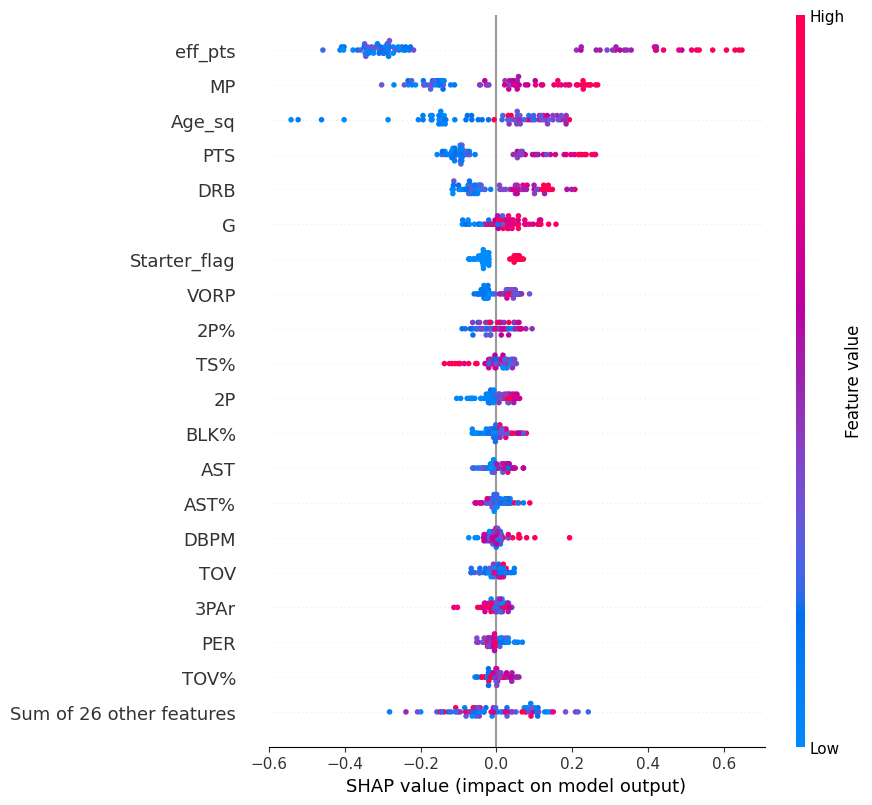

In [148]:
# Create SHAP explainer for XGBoost
explainer = shap.Explainer(best_xgb_model)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Visualize global feature importance
shap.plots.beeswarm(shap_values, max_display=20)

## Feature Importance (Gain-Based)

As a secondary check, we visualized feature importance directly from the XGBoost model using gain-based scores. While not as interpretable as SHAP, this method shows which features most frequently appear in high-impact splits.


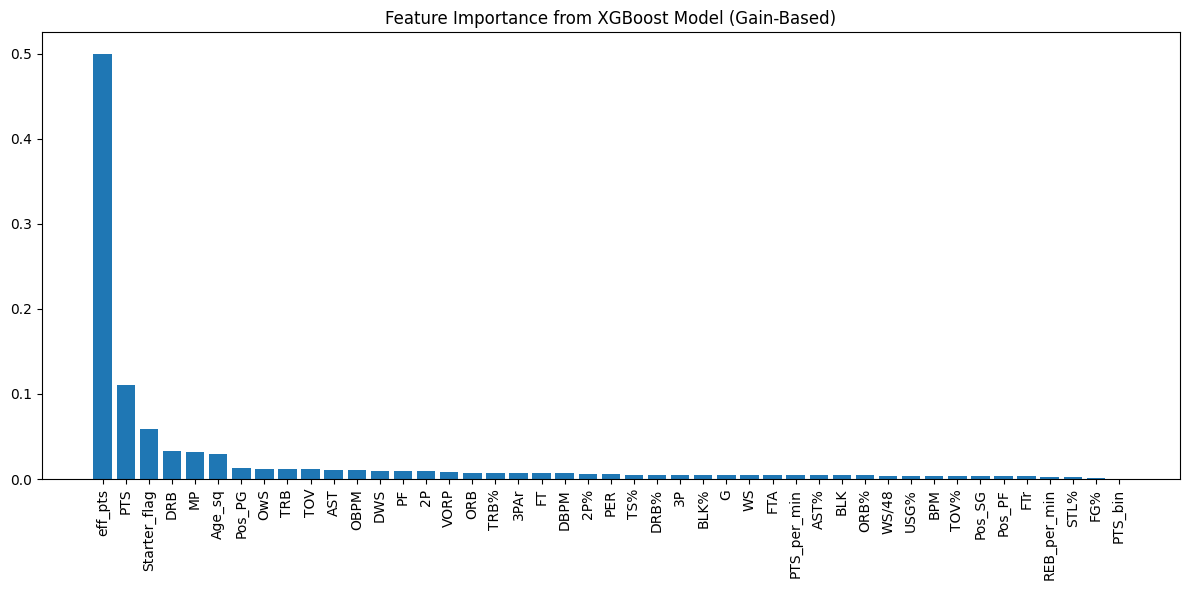

In [149]:
importance = best_xgb_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(importance)), importance[indices], align='center')
plt.xticks(range(len(importance)), feature_names[indices], rotation=90)
plt.title("Feature Importance from XGBoost Model (Gain-Based)")
plt.tight_layout()
plt.show()

## Identifying Potentially Overpaid and Underpaid Players

To analyze salary fairness, we compared each player’s **actual 2024–25 contract** to their **model-predicted salary**. Players whose actual salary far exceeds the predicted value may be considered overpaid (based on 2023–24 performance), while those paid less than predicted may be undervalued.

This approach doesn’t account for off-court value, leadership, or injuries — but provides a strong baseline using data alone.


In [150]:
# Predict on full dataset
df['predicted_log_contract'] = best_xgb_model.predict(X)
df['predicted_contract'] = np.expm1(df['predicted_log_contract'])  # convert back to dollars

# Calculate difference between actual and predicted salaries
df['overpay_gap'] = df['Contract 2024-25'] - df['predicted_contract']

# Add back the player names for analysis
df['Player'] = one_hot_encoded_df['Player'].values

# Add 'Team' column back from the one-hot encoded version
df['Team'] = one_hot_encoded_df['Team'].values
df = df[df['Team']!= '2TM']

# Sort to find most overpaid and underpaid
most_overpaid = df.sort_values(by='overpay_gap', ascending=False).head(10)
most_underpaid = df.sort_values(by='overpay_gap').head(10)


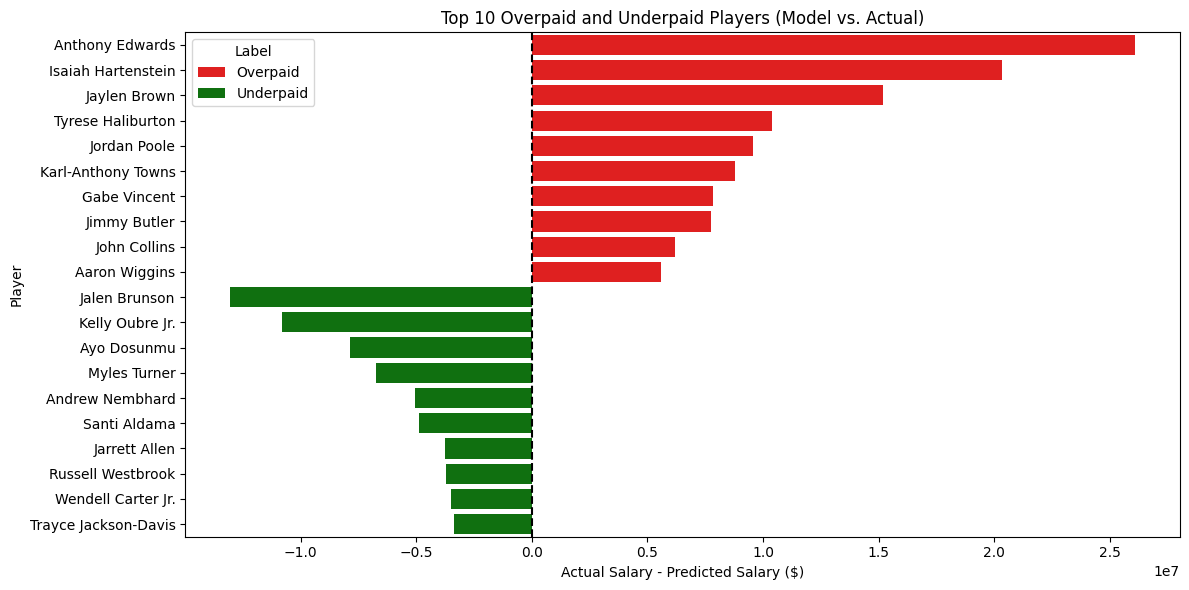

In [151]:
# Concatenate both DataFrames and add a label
top_over = most_overpaid.copy()
top_over['Label'] = 'Overpaid'

top_under = most_underpaid.copy()
top_under['Label'] = 'Underpaid'

top_players = pd.concat([top_over, top_under])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_players,
    x='overpay_gap',
    y='Player',
    hue='Label',
    dodge=False,
    palette={'Overpaid': 'red', 'Underpaid': 'green'}
)
plt.axvline(0, color='black', linestyle='--')
plt.title('Top 10 Overpaid and Underpaid Players (Model vs. Actual)')
plt.xlabel('Actual Salary - Predicted Salary ($)')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

C:\Users\ahsan\AppData\Local\Temp\ipykernel_93748\3957578120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Payment Status'] = np.where(df['overpay_gap'] > 0, 'Overpaid', 'Underpaid')


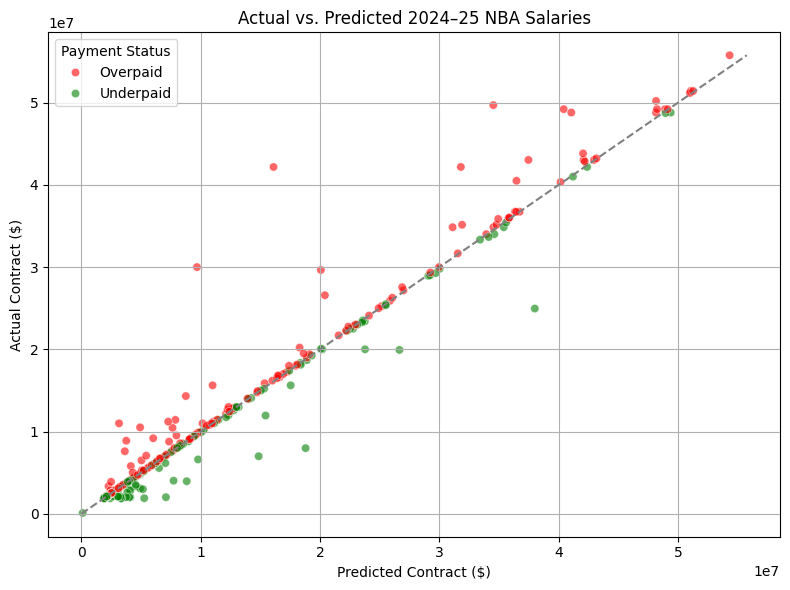

In [152]:
# Create a label column for plotting
df['Payment Status'] = np.where(df['overpay_gap'] > 0, 'Overpaid', 'Underpaid')

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='predicted_contract',
    y='Contract 2024-25',
    hue='Payment Status',
    palette={'Overpaid': 'red', 'Underpaid': 'green'},
    data=df,
    alpha=0.6
)

# Plot the y = x line
max_val = max(df['predicted_contract'].max(), df['Contract 2024-25'].max())
plt.plot([0, max_val], [0, max_val], linestyle='--', color='gray')

plt.xlabel('Predicted Contract ($)')
plt.ylabel('Actual Contract ($)')
plt.title('Actual vs. Predicted 2024–25 NBA Salaries')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Payment Status')
plt.show()

## Team-Level Salary Insights

To better understand how teams allocate salaries in relation to player performance, we explored team-level patterns from two angles:

### Most Overpaid and Most Underpaid Players Per Team

For each team, we identified:
- The most overpaid player: the player with the largest positive difference between actual and model-predicted salary
- The most underpaid player: the player with the largest negative difference (i.e., paid far less than the model expects)

We visualized these findings with a dual bar chart, where:
- Red bars show the dollar amount a team is overpaying its top overpaid player
- Green bars show how much value they’re getting from their most underpaid player

This provides a side-by-side comparison of the best and worst salary decisions on every roster.

### Best and Worst Teams by Salary Efficiency

To evaluate teams as a whole, we aggregated the `overpay_gap` across all players per team:

- Teams with a negative total gap are paying less than the model-predicted value for their rosters — indicating strong cap efficiency
- Teams with a positive total gap are overpaying relative to player performance

We ranked and visualized the top 5 most salary-efficient teams and the top 5 least efficient teams, offering a high-level view of cap management across the league.

### Key Takeaways

- Some teams showed a strong contrast — featuring both major overpays and hidden-value players on the same roster
- A few teams (e.g., MIN, WAS) had consistently poor salary alignment, suggesting systemic overvaluation
- Others (e.g., CHI, PHI) consistently underpaid their talent, indicating potential value in their roster construction

This analysis highlights where NBA front offices may be over- or undervaluing players, and how performance-based models can support more efficient contract decisions.

In [153]:
# Most overpaid = largest positive gap
most_overpaid_per_team = df.loc[df.groupby('Team')['overpay_gap'].idxmax()]

# Most underpaid = largest negative gap
most_underpaid_per_team = df.loc[df.groupby('Team')['overpay_gap'].idxmin()]

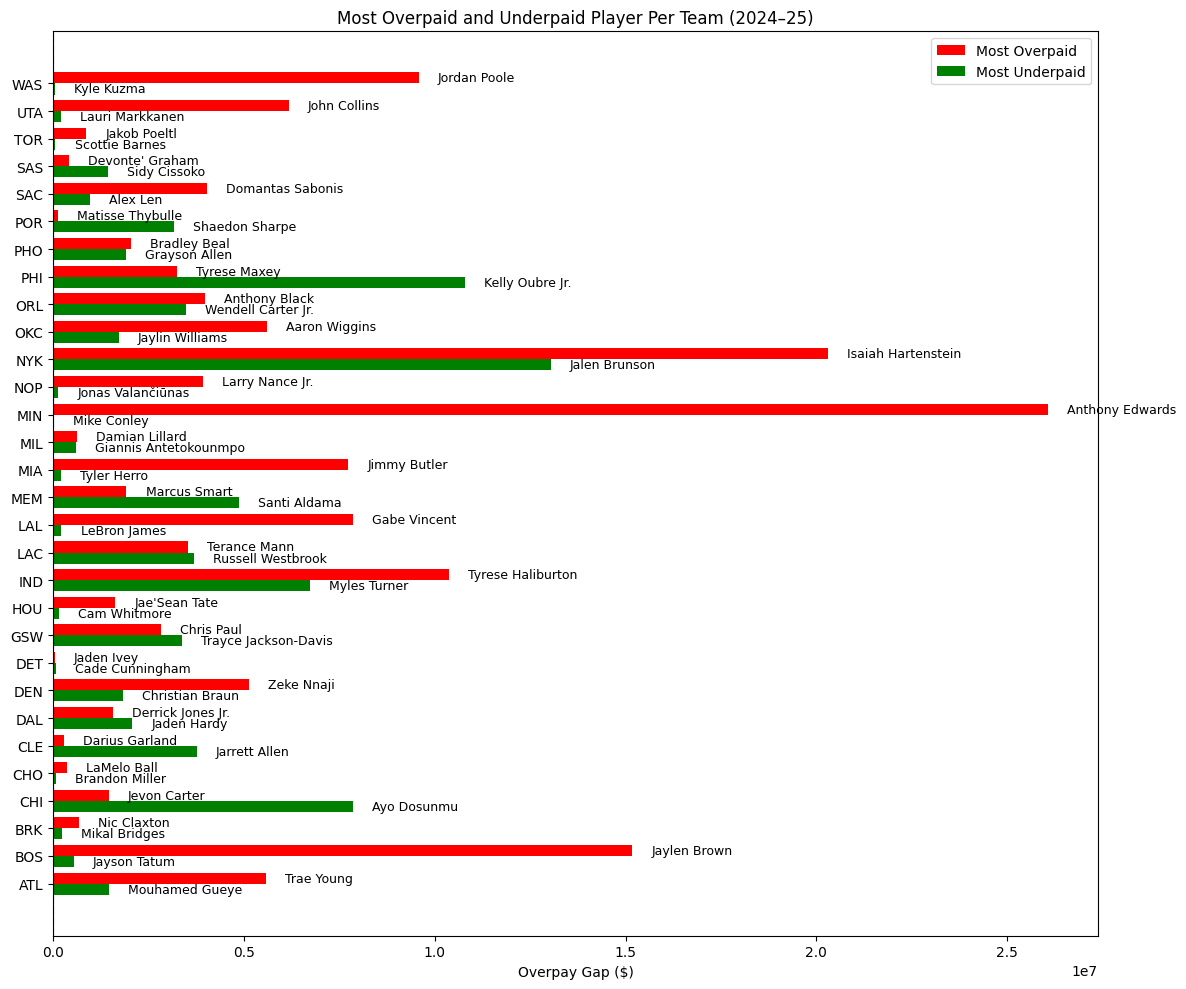

In [154]:
# Sort both datasets by team
most_overpaid_sorted = most_overpaid_per_team.sort_values('Team')
most_underpaid_sorted = most_underpaid_per_team.sort_values('Team')

teams = most_overpaid_sorted['Team']
y_pos = range(len(teams))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(12, 10))

# Red bars for most overpaid players
overpaid_bars = ax.barh(
    [y + bar_width / 2 for y in y_pos],
    most_overpaid_sorted['overpay_gap'],
    height=bar_width,
    color='red',
    label='Most Overpaid'
)

# Green bars for most underpaid players (invert gap)
underpaid_bars = ax.barh(
    [y - bar_width / 2 for y in y_pos],
    -most_underpaid_sorted['overpay_gap'],
    height=bar_width,
    color='green',
    label='Most Underpaid'
)

# Add player name labels at end of bars
for i, (op_row, up_row) in enumerate(zip(most_overpaid_sorted.itertuples(), most_underpaid_sorted.itertuples())):
    # Overpaid label (right side of bar)
    ax.text(
        op_row.overpay_gap + 500000,  # small padding for clarity
        y_pos[i] + bar_width / 2,
        op_row.Player,
        va='center',
        ha='left',
        fontsize=9,
        color='black'
    )
    # Underpaid label (right side of inverted bar)
    ax.text(
        -up_row.overpay_gap + 500000,
        y_pos[i] - bar_width / 2,
        up_row.Player,
        va='center',
        ha='left',
        fontsize=9,
        color='black'
    )

# Final plot setup
ax.set_yticks(y_pos)
ax.set_yticklabels(teams)
ax.set_xlabel('Overpay Gap ($)')
ax.set_title('Most Overpaid and Underpaid Player Per Team (2024–25)')
ax.axvline(0, color='black', linestyle='--')
ax.legend()
plt.tight_layout()
plt.show()

In [155]:
# Group by team and sum overpay gaps
team_value = df.groupby('Team')['overpay_gap'].sum().sort_values()

# Top 5 best value teams (lowest total overpay)
best_teams = team_value.head(5)

# Top 5 worst value teams (highest total overpay)
worst_teams = team_value.tail(5)

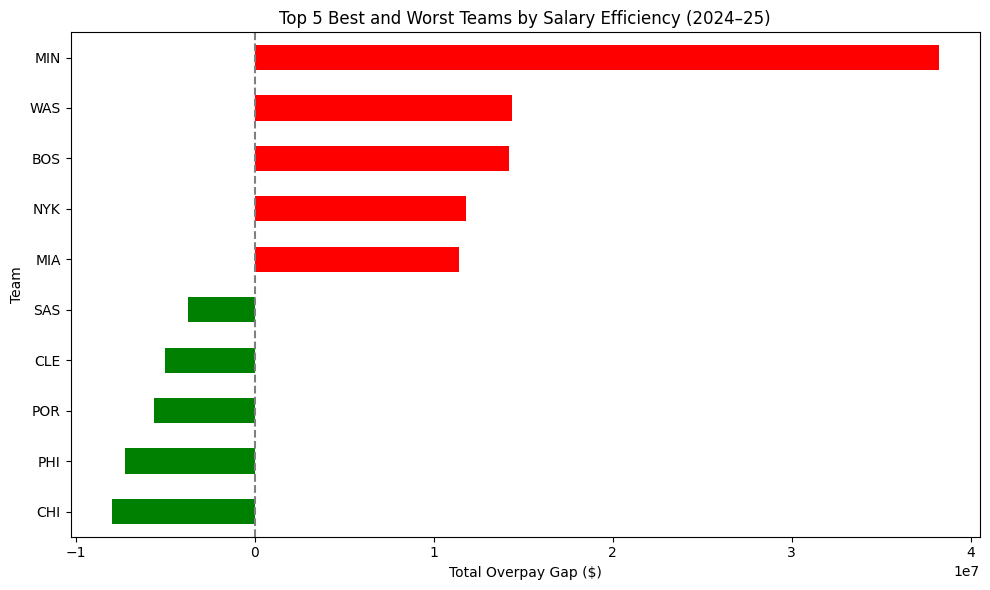

In [156]:
plt.figure(figsize=(10, 6))

# Plot best and worst together
combined = pd.concat([best_teams, worst_teams])

colors = ['green'] * 5 + ['red'] * 5

combined.plot(kind='barh', color=colors)
plt.axvline(0, linestyle='--', color='gray')
plt.xlabel('Total Overpay Gap ($)')
plt.title('Top 5 Best and Worst Teams by Salary Efficiency (2024–25)')
plt.tight_layout()
plt.show()

## Conclusion

This project used machine learning to predict 2024–25 NBA player contract values based on 2023–24 season performance statistics. We engineered a robust dataset that combined traditional box score stats, advanced metrics, and custom performance features to model salary outcomes.

After training and tuning multiple regression models, our best-performing model — an XGBoost regressor — achieved:

- **R² Score:** 0.80  
- **Root Mean Squared Error (RMSE):** approximately \$5.85 million

This indicates that the model explains 80% of the variance in NBA contract values, and typically predicts salaries within \$5.85M of actual contracts — a strong result given the real-world volatility in player contracts.

By comparing model predictions to actual contracts, we were able to:
- Identify the most overpaid and underpaid players based on statistical performance
- Analyze team-level salary efficiency
- Visualize outliers and potential market inefficiencies in the NBA's salary landscape

While the model captures a large portion of performance-driven salary variation, it does not account for contextual factors such as injury history, marketability, leadership, or cap-space dynamics. Nonetheless, it offers a powerful data-driven lens for evaluating contract fairness and roster construction.

This approach could be valuable for front offices, analysts, and fans alike — and could be extended further by incorporating additional seasons, player context variables, or applying the framework to other professional sports leagues.